In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [3]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Basics
import os
import sys
import time
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators.simulator import simulator

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

import jax
jax.config.update("jax_enable_x64", False)

import src.utils.setup_figures as figures
import src.utils.basic as utils


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# exclude the following subjects where categorization score is more than 2
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 2]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]
processed_data = data.loc[~data["subject"].isin(reject_subs)]


## Model

In [5]:
processed_data.head()

,subject,medication,prior,prior_direction,prior_color,color,coherence,target,is_valid,outcome,choice,reaction_time,session_name,signed_coherence
0,CG,off,rl,left,red,1,100.0,1,True,True,1,626.976669,Brady_CG_OFFmeds_rl.mat,100.0
1,CG,off,rl,left,red,-1,0.0,1,True,False,-1,945.801775,Brady_CG_OFFmeds_rl.mat,0.0
2,CG,off,rl,left,red,-1,0.0,-1,True,False,1,964.249405,Brady_CG_OFFmeds_rl.mat,-0.0
3,CG,off,rl,left,red,-1,100.0,-1,True,True,-1,671.215080,Brady_CG_OFFmeds_rl.mat,-100.0
4,CG,off,rl,left,red,-1,0.0,1,True,True,1,1046.959465,Brady_CG_OFFmeds_rl.mat,0.0


### Loading Dataset

processed_data  
&ensp;&ensp;color: &ensp;&ensp;&ensp;&ensp;&ensp;{prior: 1, equal: -1}  
&ensp;&ensp;direction: &ensp;&ensp;{prior: 1, equal: -1}

In [6]:
model_data = pd.DataFrame(
    {
        "rt": data["reaction_time"]/1000,
        "response": data["choice"],
        "stimulus": data["signed_coherence"]/100,
        "treatment": data["medication"].replace({"off": 0, "on": 1}).astype("category"),
        "subject": processed_data["subject"],
    }
)

In [7]:
subjects = processed_metadata["subject_id"].values


angle.onnx:   0%|          | 0.00/85.3k [00:00<?, ?B/s]

Model initialized successfully.


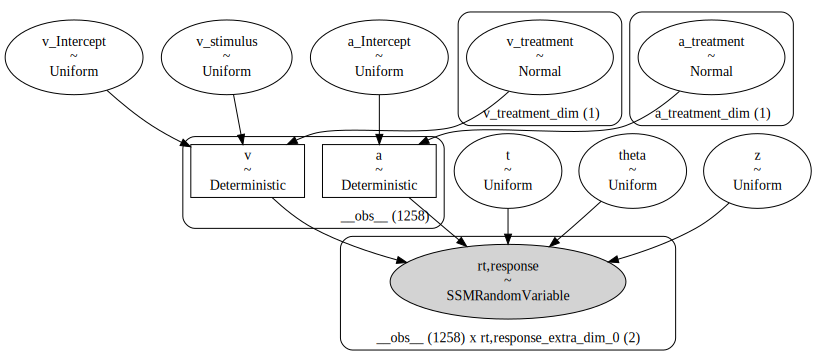

In [8]:
model_reg_v_a = hssm.HSSM(
    data=model_data.loc[model_data["subject"] == subjects[0]],
    model="angle",
    include = [
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "stimulus":  {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            },
            "formula": "v ~ stimulus + treatment",
            "link": "identity",
            
        },
        {
            "name": "a",
            "prior": {"Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},},
            "formula": "a ~ treatment",
        },
        
    ]
    
)

model_reg_v_a.graph()



Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:04<00:00, 498.96it/s]


array([[<Axes: title={'center': 'theta'}>, <Axes: title={'center': 't'}>,
        <Axes: title={'center': 'v_treatment\n1'}>,
        <Axes: title={'center': 'a_Intercept'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'z'}>,
        <Axes: title={'center': 'v_stimulus'}>,
        <Axes: title={'center': 'a_treatment\n1'}>]], dtype=object)

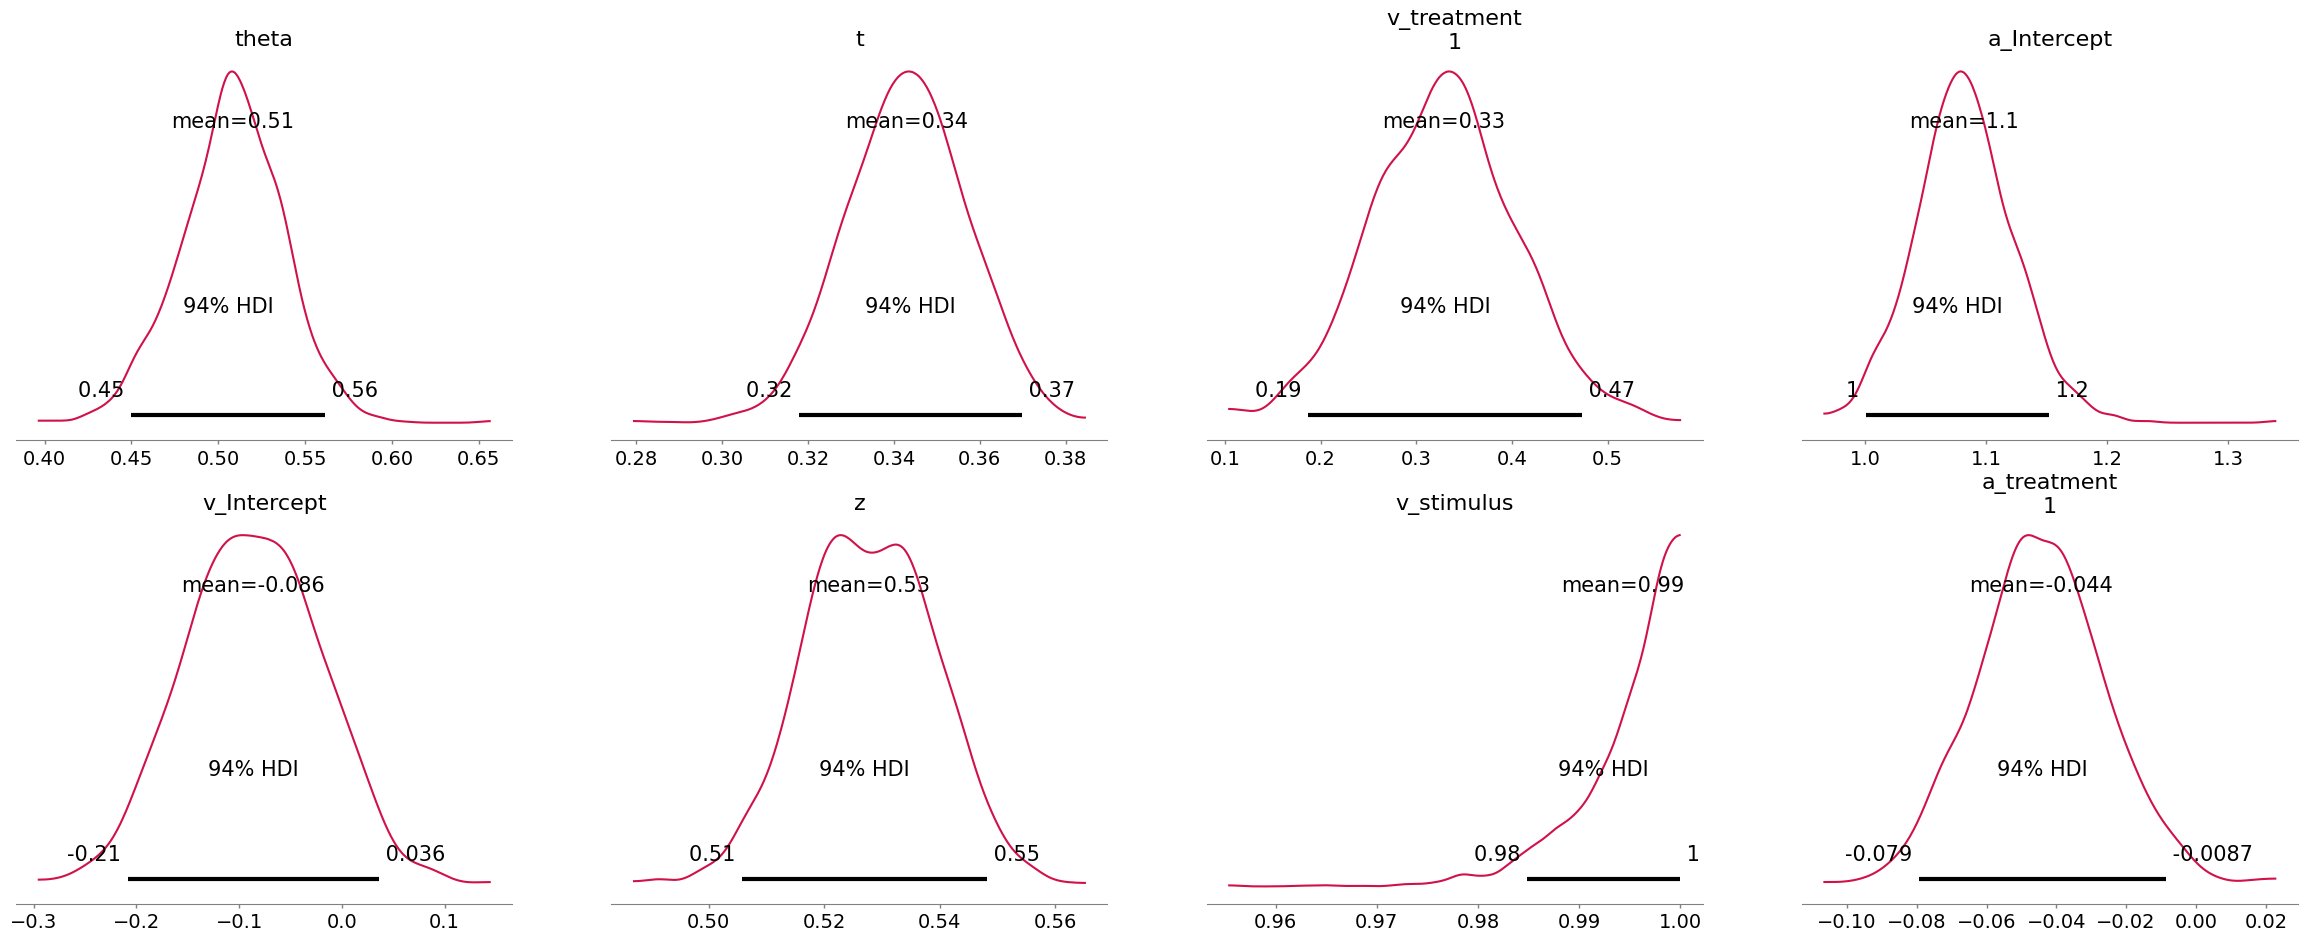

Bad pipe message: %s [b'"Chromium";v="130", "Google Chrome";v="130", "Not?A_Brand']


In [31]:
idata = model_reg_v_a.sample(
    sampler="nuts_numpyro", chains=4, cores=4, draws=500, tune=500
) 
az.plot_posterior(model_reg_v_a.traces)